In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
import seaborn as sns

In [4]:
path = "data/Tweets.csv"

In [5]:
df = pd.read_csv(path)

# Some preprocessing and taking a look at the data

In [6]:
df.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [7]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [8]:
df.dropna()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [9]:
category_id = {
    'neutral':1,
    'negative': 0,
    'positive': 2
}

In [10]:
df['class'] = df['sentiment'].map(category_id)

In [11]:
df.head()

,textID,text,selected_text,sentiment,class
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0
2,088c60f138,my boss is bullying me...,bullying me,negative,0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0


# Hyperparam settings

In [12]:
BATCH_SIZE=512
NUM_EPOCHS = 80

In [13]:
X = df['text'].values
y = df['class'].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.shape

(21984,)

In [16]:
X_train

array(['Doctor Who has finished', ' you should.',
       'back at school again. almost weekend. oh wait, i gotta work from eight to four tonight',
       ...,
       'is sitting thru the boring bits in Titanic waiting for the good bit to start in couple of hours',
       'Missed the play',
       'Oh I`m really tired of these migraines! #Endometriosis & #Fibromyalgia & #Migraines & sleep probs just compoundin ea other since surgery'],
      dtype=object)

# OHE

In [17]:
one_hot = CountVectorizer()

In [18]:
X_train_ohe = one_hot.fit_transform(X_train.astype('U'))
X_test_ohe = one_hot.transform(X_test.astype('U'))

In [19]:
X_train_ohe

<21984x23036 sparse matrix of type '<class 'numpy.int64'>'
	with 251401 stored elements in Compressed Sparse Row format>

In [20]:
## Initialize a dataset class

class SentimentData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X.toarray())
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [21]:
train_ds = SentimentData(X=X_train_ohe, y=y_train)
test_ds = SentimentData(X_test_ohe, y_test)

In [22]:
# Dataloader
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_ds, batch_size=15000)

In [23]:
# First model - 1 hidden layer
class SentimentModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN=10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x


# Model, Loss, and Optimizer

In [24]:
model = SentimentModel(NUM_FEATURES=X_train_ohe.shape[1], NUM_CLASSES=3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [25]:
# Model training loop

train_losses = []

for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())

        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(curr_loss)
    print(f"Epoch {e+1}, Loss: {curr_loss}")

Epoch 1, Loss: 46.198302030563354
Epoch 2, Loss: 42.5823615193367
Epoch 3, Loss: 38.424820363521576
Epoch 4, Loss: 34.43505275249481
Epoch 5, Loss: 30.919039130210876
Epoch 6, Loss: 27.9362576007843
Epoch 7, Loss: 25.422067761421204
Epoch 8, Loss: 23.291050732135773
Epoch 9, Loss: 21.480659514665604
Epoch 10, Loss: 19.918626874685287
Epoch 11, Loss: 18.565919250249863
Epoch 12, Loss: 17.358234763145447
Epoch 13, Loss: 16.291173696517944
Epoch 14, Loss: 15.328276127576828
Epoch 15, Loss: 14.476417660713196
Epoch 16, Loss: 13.697903245687485
Epoch 17, Loss: 12.98962315917015
Epoch 18, Loss: 12.348355129361153
Epoch 19, Loss: 11.75837618112564
Epoch 20, Loss: 11.219238564372063
Epoch 21, Loss: 10.729280099272728
Epoch 22, Loss: 10.261209353804588
Epoch 23, Loss: 9.835296511650085
Epoch 24, Loss: 9.435536101460457
Epoch 25, Loss: 9.073822617530823
Epoch 26, Loss: 8.729820549488068
Epoch 27, Loss: 8.409066498279572
Epoch 28, Loss: 8.107614621520042
Epoch 29, Loss: 7.835522174835205
Epoch 30

# Taking a look at training results

<Axes: >

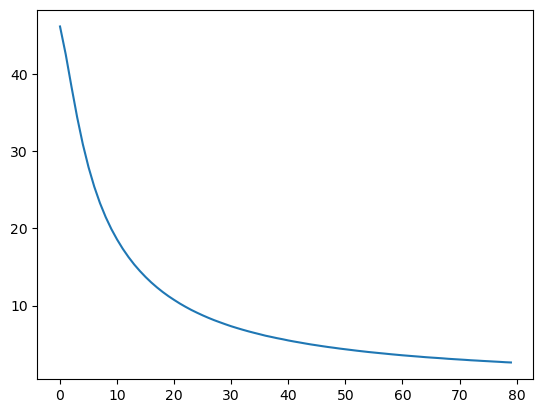

In [27]:
sns.lineplot(x=list(range(len(train_losses))), y=train_losses)

# Now evaluating the model performance

In [28]:
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred_log = model(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim=1)

In [29]:
y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

In [30]:
acc = accuracy_score(y_pred=y_test_pred_np, y_true=y_test)
f"The accuracy of the model is {np.round(acc,3)*100}%."

'The accuracy of the model is 64.5%.'

In [33]:
## Naive classifier to show model does indeed perform better than the most likely scenario

most_common_count = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {np.round(most_common_count / len(y_test) * 100, 1)} %")

Naive Classifier: 40.6 %


<Axes: >

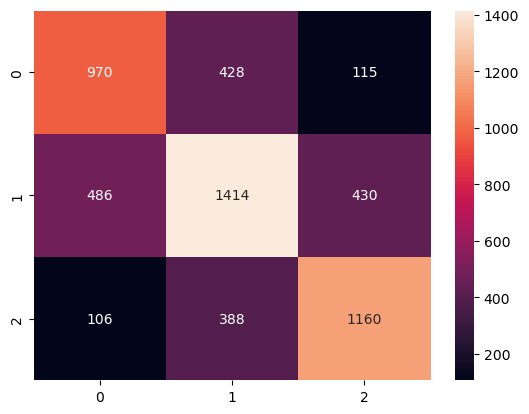

In [32]:
sns.heatmap(confusion_matrix(y_test_pred_np, y_test), annot=True, fmt=".0f")